# Bootcamp FIAP - Turma 11IA

### Integrantes:

###    1) Fabio Rizzi - RM336656
###    2) Jurandir Ventura - RM336634
###    3) Marcelo Preto - RM336632
###    4) Thiago Alexandre – RM336583

## Desafio Bootcamp:

### Analisar o dataset de atendimentos de manutenção da empresa VIVANTE no Hospital Metropolitano e trazer insights e soluções de Machine Learning ou Deep Learning para convergir com o objetivo da empresa em liderar o mercado de Facilities com tecnologias e conhecimento disruptivos.

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# Preparação do dataset
df = pd.read_excel('dataset/VIVANTE_DATASET_PIVOTADO_V1.xlsx')
print("Shape Original", df.shape)
print(list(df.columns))
print("")

#Removendo linhas com estados inválidos para não estragar o modelo de previsão baseado no histórico de tempo de atividade
print("Removendo estados não finalizados")
df.drop(df[df['Estado OS'] == "AB"].index, inplace=True) # Aberto
df.drop(df[df['Estado OS'] == "CC"].index, inplace=True) # Cancelado
df.drop(df[df['Estado OS'] == "EX"].index, inplace=True) # Em Execucao
df.drop(df[df['Estado OS'] == "NE"].index, inplace=True) # Nao Executado
df.drop(df[df['Estado OS'] == "PR"].index, inplace=True) # Programada

# Removendo linhas de diálogo diário de segurança
print("Shape1:", df.shape)
df.drop(df[df['Denominação OS'] == "DDS (DIÁLOGO DIÁRIO DE SEGURANÇA)"].index, inplace=True)
print("Shape2:", df.shape)

#Removendo colunas desnecessárias
df.drop(columns=['Número OS','Descrição Ativo','Estado OS','Denominação OS','Denominação Estado OS',
                 'Descrição Classe de Trabalho', 'Descrição Atividade', 'Previsão 1º Atend.',
                 'Descrição Roteiro', 'nome_tecn','Tempo Trabalho Convertido','Data da Criação',
                 'Data/Hora Abertura', 'Data Início Trabalho', 'Data Final Trabalho',
                 'Data/Hora de Conclusão', 'Roteiro'], inplace=True)
df.rename(columns={'Tempo Trabalho Feedback M.Obra': 'Tempo_Trabalhado_Real',
                    'Denominação OS': 'Denominacao_OS',
                    'Classe de Trabalho': 'Classe_Trabalho',
                    'Técnico': 'Tecnico',
                    'Tempo Previsto': 'Tempo_Previsto'}, inplace=True)
print("Colunas após removidas as desnecessárias:")
print(list(df.columns))
print("")

# Removendo nulos
df.dropna(inplace=True)
print("Shape removido nulos", df.shape)
print("")

# Uppercase em colunas de Texto
df['Ativo']=df['Ativo'].apply(lambda x: x.upper())
df['Atividade']=df['Classe_Trabalho'].apply(lambda x: x.upper())
df['Classe_Trabalho']=df['Classe_Trabalho'].apply(lambda x: x.upper())
df['Tecnico']=df['Tecnico'].apply(lambda x: x.upper())

Shape Original (34106, 23)
['Número OS', 'Denominação OS', 'Ativo', 'Descrição Ativo', 'Estado OS', 'Denominação Estado OS', 'Classe de Trabalho', 'Descrição Classe de Trabalho', 'Atividade', 'Descrição Atividade', 'Data da Criação', 'Data/Hora Abertura', 'Data/Hora de Conclusão', 'Previsão 1º Atend.', 'Roteiro', 'Descrição Roteiro', 'Data Início Trabalho', 'Data Final Trabalho', 'Tempo Trabalho Feedback M.Obra', 'Tempo Trabalho Convertido', 'Técnico', 'nome_tecn', 'Tempo Previsto']

Removendo estados não finalizados
Shape1: (33576, 23)
Shape2: (31100, 23)
Colunas após removidas as desnecessárias:
['Ativo', 'Classe_Trabalho', 'Atividade', 'Tempo_Trabalhado_Real', 'Tecnico', 'Tempo_Previsto']

Shape removido nulos (30555, 6)



In [3]:
# Reorganizando dataframe
df = df[['Ativo', 'Atividade', 'Classe_Trabalho', 'Tecnico', 'Tempo_Trabalhado_Real','Tempo_Previsto']]

In [4]:
tempo_previsto = df['Tempo_Previsto']
tempo_real = df['Tempo_Trabalhado_Real']

In [5]:
df.drop(columns = ['Tempo_Previsto'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30555 entries, 2 to 34104
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ativo                  30555 non-null  object 
 1   Atividade              30555 non-null  object 
 2   Classe_Trabalho        30555 non-null  object 
 3   Tecnico                30555 non-null  object 
 4   Tempo_Trabalhado_Real  30555 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [6]:
df.head()

,Ativo,Atividade,Classe_Trabalho,Tecnico,Tempo_Trabalhado_Real
2,HMBHPA1PVWC014,COR,COR,VB104104,0.250000
3,HMBHPA3PVCME01,COR,COR,VB220999,0.733333
4,1E01,PRS,PRS,VB217522,0.400000
5,1E01,PRS,PRS,VB217522,0.733333
6,1E02,PRS,PRS,VB217522,0.250000


- Features: Ativo, Classe_Trabalho, Atividade, Tecnico
- Target: Tempo_Trabalhado_Real

In [7]:
value_counts = df['Tempo_Trabalhado_Real'].value_counts()
to_remove = value_counts[value_counts < 3].index
df = df[~df['Tempo_Trabalhado_Real'].isin(to_remove)]
print(df['Tempo_Trabalhado_Real'].value_counts())

0.500000    4216
1.000000    1877
0.333333    1832
0.416667    1816
0.666667    1646
            ... 
2.400000       3
4.716667       3
2.366667       3
2.700000       3
2.950000       3
Name: Tempo_Trabalhado_Real, Length: 210, dtype: int64


In [8]:
scaler = StandardScaler()
y = scaler.fit_transform(df[['Tempo_Trabalhado_Real']])
encoder = OneHotEncoder()
X = encoder.fit_transform(df[['Ativo','Atividade','Classe_Trabalho','Tecnico']])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [10]:
# modelo sequencial
model = Sequential()

# Input
model.add(Dense(1024, input_dim=X.shape[-1], activation='relu'))

# Hidden
model.add(Dense(512, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

# Output
model.add(Dense(1, activation='linear'))

# Compile
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3547136   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [11]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=60, verbose=1, shuffle=True)

Epoch 1/60
191/191 [==============================] - 1s 4ms/step - loss: 0.4833 - mean_absolute_error: 0.4833
Epoch 2/60
191/191 [==============================] - 1s 4ms/step - loss: 0.3744 - mean_absolute_error: 0.3744
Epoch 3/60
191/191 [==============================] - 1s 4ms/step - loss: 0.3326 - mean_absolute_error: 0.3326
Epoch 4/60
191/191 [==============================] - 1s 4ms/step - loss: 0.3081 - mean_absolute_error: 0.3081
Epoch 5/60
191/191 [==============================] - 1s 4ms/step - loss: 0.2901 - mean_absolute_error: 0.2901
Epoch 6/60
191/191 [==============================] - 1s 4ms/step - loss: 0.2765 - mean_absolute_error: 0.2765
Epoch 7/60
191/191 [==============================] - 1s 4ms/step - loss: 0.2659 - mean_absolute_error: 0.2659
Epoch 8/60
191/191 [==============================] - 1s 4ms/step - loss: 0.2563 - mean_absolute_error: 0.2563
Epoch 9/60
191/191 [==============================] - 1s 4ms/step - loss: 0.2473 - mean_absolute_error: 0.2473
E

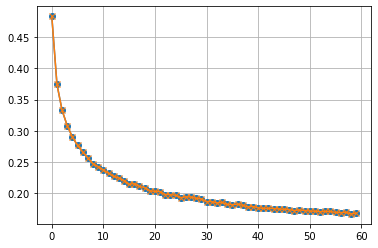

In [12]:
plt.figure(1)
plt.plot(hist.history['loss'], 'o-')
plt.plot(hist.history['mean_absolute_error'], 'x-')
plt.grid(True)
plt.show()

In [13]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

191/191 [==============================] - 0s 2ms/step - loss: 0.3077 - mean_absolute_error: 0.3077

mean_absolute_error: 30.77%


In [14]:
print("Erro médio absoluto previsto no sistema da Vivante: ", round(mean_absolute_error(tempo_real, tempo_previsto)*100,2))

Erro médio absoluto previsto no sistema da Vivante:  189.5


<h1>Conclusão:<h1>

1) Enquanto a previsão original possui um erro médio absoluto aproximado de 190%, nosso modelo foi capaz de estimar o tempo de realização com erro médio de aproximadamente 30%, gerando grande economia de tempo de reserva, baseando-se em apenas nas variáveis 'Ativo', 'Atividade', 'Classe_Trabalho' e 'Tecnico'.
    
2) Para a outra linha de pesquisa, que é agregar valor ao contrato, é necessário instalação de IoT e sensoriamento para incluir no Dataset e criar os modelos de manutenção prescristiva e detecção de anomalia.